### Import necessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

### Check if GPU is available or not

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define dataset directory

In [3]:
dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Refined/"

### Define some parameters for model

In [52]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 64
EPOCHS = 12
BASE_MODELS = ["vgg16", "resnet101", "densenet169"]

### Create object of ImageDataGenerator to load the data for training and validation

In [5]:
datagen = ImageDataGenerator(
  rescale=1./255,
  width_shift_range=0.1,
  height_shift_range=0.1,
  # shear_range=0.1,
  zoom_range=0.2,
  # horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2
)

### Load the training data from train folder (split images from train folder as specified in datagen object)

In [6]:
train_generator = datagen.flow_from_directory(
  dataset_path + "train",
  subset="training",
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 3597 images belonging to 3 classes.


### Load the model validation data from train folder (split images from train folder as specified in datagen object)

In [7]:
val_generator = datagen.flow_from_directory(
  dataset_path + "train",
  subset="validation",
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 899 images belonging to 3 classes.


### Examine the classes

In [8]:
class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)
print(class_names)

['COVID', 'Normal', 'Viral Pneumonia']


In [9]:
# base_model = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')
# base_model = ResNet101(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights='imagenet')
# base_model = DenseNet169(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')

### Define a function to choose base Model for transfer learning

In [10]:
def get_model(model_sel):
  if model_sel == 1:
    vgg_pre_t = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')
    return vgg_pre_t, 25088

  elif model_sel == 2:
    resnet_pre_t = ResNet101(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights='imagenet')
    return resnet_pre_t, 100352

  elif model_sel == 3:
    densenet169_pre_t = DenseNet169(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet' )
    return densenet169_pre_t, 81536

### Choose one Model

In [11]:
select_model = 1 # int(input("Enter the number for: \n 1) VGG16 \n 2) Resnet101  \n 3) Densenet169 "))

### Get the chosen Model

In [12]:
base_model, feature_size = get_model(select_model)

### Freeze the layers of base model as training is not needed for them

In [13]:
print(len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = False

19


### Make some customization on the output layer of base Model

In [14]:
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = MaxPooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = Flatten()(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)
print(x.shape, predictions.shape)

(None, 25088) (None, 3)


### Initialize expert model based on base Model

In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

### Compile expert Model

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train expert Model

In [68]:
train_data_distribution = np.unique(train_generator.classes, return_counts=True)
class_weight = {key: train_data_distribution[1][key] for key in train_data_distribution[0]}
print(class_weight)
class_weight = { key: class_weight[0]/class_weight[key] for key in class_weight.keys() }
print(class_weight)
class_weight = {0: 1.08, 1: 1.1, 2: 4.9}
print(class_weight)

history = model.fit(train_generator,
            steps_per_epoch=len(train_generator),
            epochs=EPOCHS,
            validation_data=val_generator,
            validation_steps=len(val_generator),
            class_weight=class_weight)

{0: 1680, 1: 1521, 2: 396}
{0: 1.0, 1: 1.1045364891518739, 2: 4.242424242424242}
{0: 1.08, 1: 1.1, 2: 4.9}
Epoch 1/12
57/57 [==============================] - 114s 2s/step - loss: 0.0926 - accuracy: 0.9703 - val_loss: 0.1847 - val_accuracy: 0.9355
Epoch 2/12
57/57 [==============================] - 43s 756ms/step - loss: 0.0698 - accuracy: 0.9780 - val_loss: 0.1706 - val_accuracy: 0.9399
Epoch 3/12
57/57 [==============================] - 43s 755ms/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.2100 - val_accuracy: 0.9210
Epoch 4/12
57/57 [==============================] - 43s 755ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.1456 - val_accuracy: 0.9499
Epoch 5/12
57/57 [==============================] - 43s 754ms/step - loss: 0.0840 - accuracy: 0.9753 - val_loss: 0.1628 - val_accuracy: 0.9511
Epoch 6/12
57/57 [==============================] - 43s 759ms/step - loss: 0.0701 - accuracy: 0.9791 - val_loss: 0.1691 - val_accuracy: 0.9410
Epoch 7/12
57/57 [===================

### Visualize the training process from accuracy

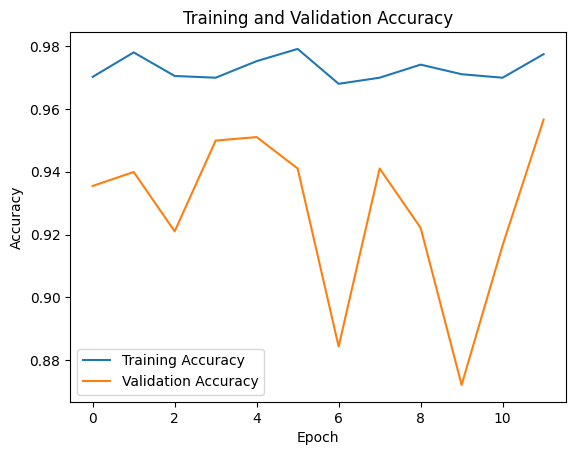

In [69]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize the training process from loss

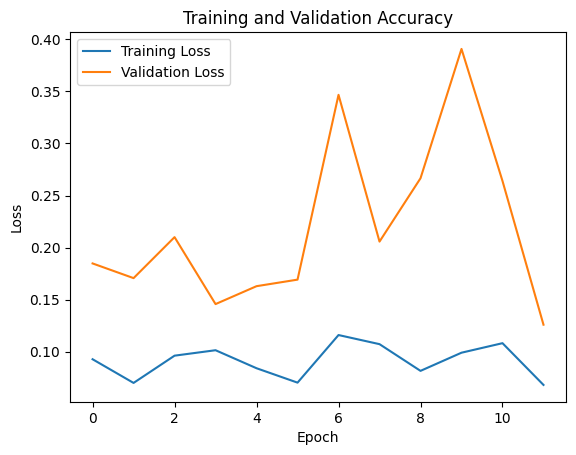

In [70]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save expert Model

In [73]:
val_accuracy_list = history.history['val_accuracy']
val_accuracy = val_accuracy_list[-1] # last epoch value

In [74]:
model_name = "./models/xray" + "_" + BASE_MODELS[select_model-1] + "_" + str(BATCH_SIZE) + "_" + str(EPOCHS) + "_expert_acc_" + str(round(val_accuracy * 100, 1)) + ".h5"
model.save(model_name)

### Import necessary models for evaluations

In [20]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

### Evaluate the Model

In [56]:
val_data, val_labels = [], []
for _ in range(len(val_generator)):
    batch_data, batch_labels = val_generator.next()
    val_data.append(batch_data)
    val_labels.append(batch_labels)

val_data = np.concatenate(val_data)
val_labels = np.concatenate(val_labels)

In [71]:
# Make predictions on the validation set
val_predictions = model.predict(val_data)

29/29 [==============================] - 1s 35ms/step


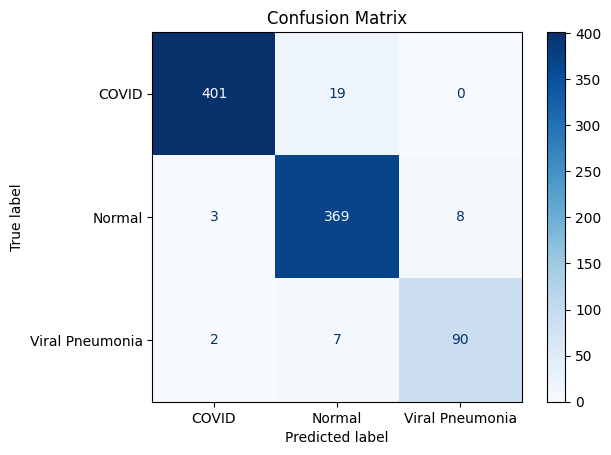

Accuracy: 0.9555061179087876
Precision: 0.9597765363128492
F1 Score: 0.9576365663322185
AUC-ROC Score: 0.9941586313305725
Confusion Matrix:
 [[401  19   0]
 [  3 369   8]
 [  2   7  90]]


In [72]:
# Convert predicted probabilities to predicted class labels
val_predicted_labels = (val_predictions > 0.5).astype(np.int8)  # Thresholding at 0.5

# p_l = [np.where(x == 1)[0][0] for x in val_predicted_labels]
p_l = [];
for x in val_predicted_labels:
    try:
        p_l.append(np.where(x == 1)[0][0])
    except:
        p_l.append(0)

t_l = [np.where(x == 1)[0][0] for x in val_labels]

# loss, accuracy = model.evaluate(val_generator, steps=len(val_generator))
accuracy = accuracy_score(val_labels, val_predicted_labels)

# Calculate precision
precision = precision_score(val_labels, val_predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(val_labels, val_predicted_labels, average='micro')

# Calculate AUC-ROC
auc_roc = roc_auc_score(val_labels, val_predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(val_labels, val_predicted_labels)
conf_matrix = confusion_matrix(t_l, p_l)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
# print("Loss:", loss)
print("Precision:", precision)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:\n", conf_matrix)

### Print Model Summary

In [27]:
# loaded_model.summary()